<a href="https://colab.research.google.com/github/jakekrafczyk/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/LS_DS_222_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

# Random Forests

## Assignment
- [ ] Read “Adopting a Hypothesis-Driven Workflow”, a blog post by a Lambda DS student about the Tanzania Waterpumps challenge.
- [ ] Continue to participate in our Kaggle challenge.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features.
- [ ] Try Ordinal Encoding.
- [ ] Try a Random Forest Classifier.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue Submit Predictions button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [2]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 194kB 2.9MB/s 
     |████████████████████████████████| 614kB 55.9MB/s 
     |████████████████████████████████| 1.5MB 53.3MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 256kB 55.8MB/s 
     |████████████████████████████████| 307kB 56.2MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 215kB 62.3MB/s 
     |████████████████████████████████| 747kB 54.2MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.5.0-py2.py3-none-any.whl size=241329 sha256=309e972b5e80ca83a54db87a02560f43a0cb17651571d7a5ee0ef98d3b37ec28
  Stored in directory: /root/.cache/pip/wheels/9b/c9/f1/4a2f30c760e017f3e2f46be999c4597a93d126ef5ea38e276f
  Created wheel for confuse: filename=confuse-1.0.0-cp36

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=0)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [4]:
train['status_group'].value_counts(normalize=True)

#baseline is 54% functional

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [5]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [7]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,longitude_MISSING,latitude_MISSING,construction_year_MISSING,gps_height_MISSING,population_MISSING,year_recorded,month_recorded,day_recorded,years,years_MISSING
27760,50.0,Kiuma,690.0,KIUMA,36.957086,-11.311964,Kwa Mkwanda Mohamed,0,Ruvuma / Southern Coast,Kawawa,Ruvuma,10,1,Tunduru,Marumba,1.0,True,VWC,Mbati Water Supply,False,2011.0,submersible,submersible,submersible,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional needs repair,False,False,False,False,False,2013,2,13,2.0,False
15161,0.0,Hesawa,NaN,DWE,33.058573,-2.595762,Kwa Lujina,0,Lake Victoria,Ilagaja,Mwanza,19,2,Magu,Kisesa,NaN,True,VWC,NaN,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,pay monthly,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional,False,False,True,True,True,2011,7,26,NaN,True
37466,0.0,Ded,NaN,DWE,35.238216,-5.168248,Kilimba A,0,Internal,Kilimba A,Dodoma,1,1,Kondoa,Ovada,NaN,True,VWC,Ovad,False,NaN,cemo,other motorpump,motorpump,vwc,user-group,pay per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional,False,False,True,True,True,2011,3,14,NaN,True
50408,0.0,Adra,1300.0,Adra/Community,36.941756,-3.336709,John,0,Pangani,Kati,Arusha,2,7,Meru,Kikatiti,120.0,True,VWC,Mambreni gravity water supply,True,2003.0,gravity,gravity,gravity,vwc,user-group,unknown,unknown,unknown,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,False,False,False,False,False,2013,4,3,10.0,False
42597,10.0,Giz,791.0,KILI WATER,37.469637,-3.393065,Kwa Iddi Mlaki,0,Pangani,Kati Chini,Kilimanjaro,3,4,Moshi Rural,Kirua Vunjo Kusini,55.0,True,WUA,Uchira water users association,True,2001.0,gravity,gravity,gravity,wua,user-group,pay per bucket,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,False,False,False,False,False,2013,9,3,12.0,False


## Interesting Variables: amount tsh, gps_height, installer, basin, population, public meeting?, recorded by, scheme management, permit, construction year, extraction type(group?/class?), management, water quality, , quantity, source, source type, source_class, waterpoint type(group?)

In [8]:
train.dtypes

amount_tsh                   float64
funder                        object
gps_height                   float64
installer                     object
longitude                    float64
latitude                     float64
wpt_name                      object
num_private                    int64
basin                         object
subvillage                    object
region                        object
region_code                    int64
district_code                  int64
lga                           object
ward                          object
population                   float64
public_meeting                object
scheme_management             object
scheme_name                   object
permit                        object
construction_year            float64
extraction_type               object
extraction_type_group         object
extraction_type_class         object
management                    object
management_group              object
payment                       object
w

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# add installer to categorical -HAS HIGH CARDINALITY AND MISSING VALUES, SO WE CONDENSE
train['installer'] = train.installer.replace(np.NaN,'OTHER')
installer = ['installer']

val['installer'] = val.installer.replace(np.NaN,'OTHER')
test['installer'] = test.installer.replace(np.NaN,'OTHER')

categorical_features = categorical_features + installer

# Combine the lists 
features = numeric_features + categorical_features 


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [11]:
# top 10 

for x in categorical_features:
  top10 = X_train[x].value_counts()[:10].index

  X_train.loc[~X_train[x].isin(top10), x] = 'OTHER'
  X_val.loc[~X_val[x].isin(top10), x] = 'OTHER'
  X_test.loc[~X_test[x].isin(top10), x] = 'OTHER'



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


OTHER          16666
Iringa          4214
Shinyanga       3998
Mbeya           3705
Kilimanjaro     3535
Morogoro        3212
Arusha          2687
Kagera          2684
Mwanza          2473
Kigoma          2221
Pwani           2125
Name: region, dtype: int64


In [12]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on training
pipeline.fit(X_train, y_train)

print ('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7387205387205387


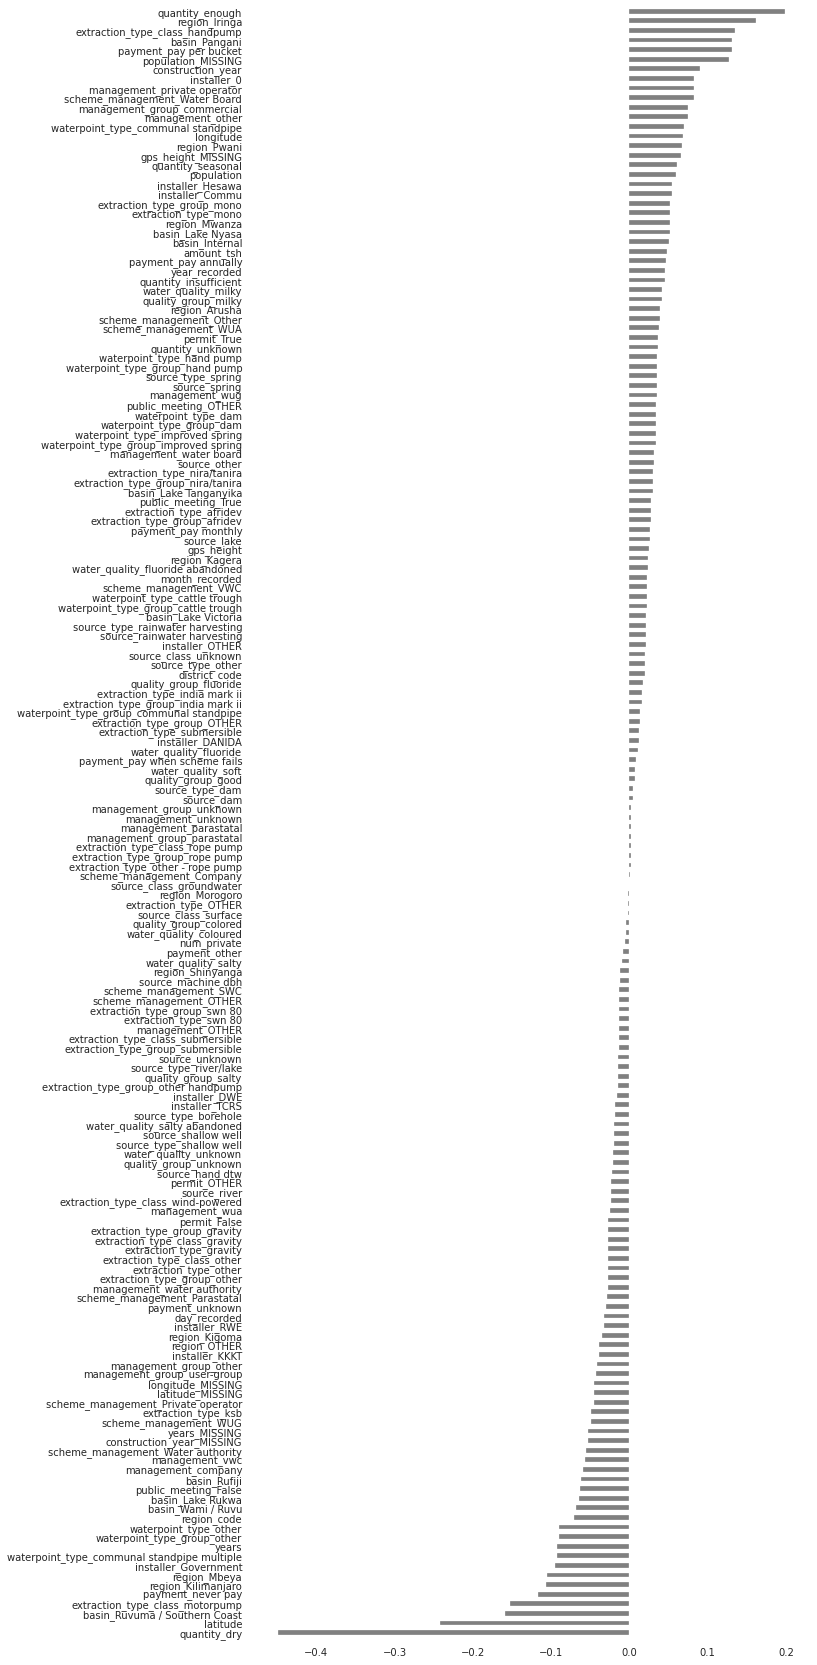

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [14]:
from sklearn.tree import DecisionTreeClassifier

#features = ['basin','region','quantity','management','waterpoint_type','construction_year','population']

#X_train2 = X_train[features]
#X_val2 = X_val[features]

pipeline2 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=0, min_samples_leaf=8,  max_leaf_nodes=600)  
)

pipeline2.fit(X_train, y_train)

print ('Training Accuracy:', pipeline2.score(X_train,y_train),'Validation Accuracy:', pipeline2.score(X_val, y_val))

Training Accuracy: 0.811679292929293 Validation Accuracy: 0.7773569023569024


In [15]:
# .774
print(numeric_features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years']


In [16]:
from sklearn.ensemble import RandomForestClassifier
# RANDOM TREE CLASSIFIER
pipeline3 = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

pipeline3.fit(X_train, y_train)
print ('Validation Accuracy', pipeline3.score(X_val, y_val))

Validation Accuracy 0.8084175084175084


In [17]:
import matplotlib.pyplot as plt

# Get encoded values
encoder = pipeline3.named_steps['onehotencoder']
encoded = encoder.transform(X_train)
print ('Print X_train shape after encoding', encoded.shape)

# Get feature importances
rf = pipeline3.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

Print X_train shape after encoding (47520, 170)


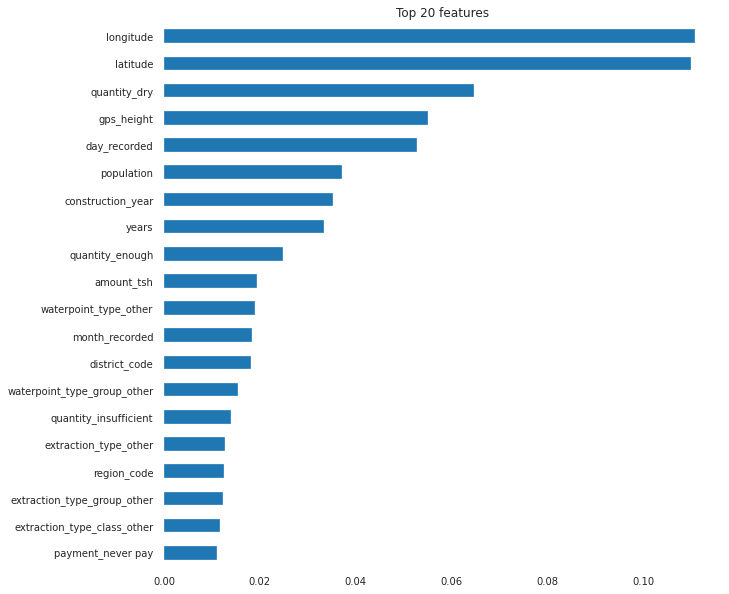

In [18]:
# Plot the top 20 features
n = 20
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [19]:
# ordinal encode
pipeline4 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=0, n_jobs=-1, min_samples_leaf=2)
)

pipeline4.fit(X_train, y_train)
print ('Training Accuracy',pipeline4.score(X_train,y_train),'Validation Accuracy', pipeline4.score(X_val, y_val))

Training Accuracy 0.924263468013468 Validation Accuracy 0.8153198653198653


In [20]:
X_train.isnull().sum()
X_test.isnull().sum()

amount_tsh                      0
gps_height                   4978
longitude                     436
latitude                      436
num_private                     0
region_code                     0
district_code                   0
population                   5205
construction_year            5024
year_recorded                   0
month_recorded                  0
day_recorded                    0
years                        5024
basin                           0
region                          0
public_meeting                  0
scheme_management               0
permit                          0
extraction_type                 0
extraction_type_group           0
extraction_type_class           0
management                      0
management_group                0
payment                         0
water_quality                   0
quality_group                   0
quantity                        0
source                          0
source_type                     0
source_class  

In [21]:
#.815

y_pred = pipeline4.predict(X_test)
print(y_pred)

['non functional' 'functional' 'functional' ... 'functional' 'functional'
 'non functional']


In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv',index=False)

In [23]:
from google.colab import files
files.download('submission-02.csv')

MessageError: ignored

In [36]:
#concat train and val
X = pd.concat([X_train,X_val])

y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)])
print(X,y)

       amount_tsh  gps_height  ...  years_MISSING  installer
27760        50.0       690.0  ...          False      OTHER
15161         0.0         NaN  ...           True        DWE
37466         0.0         NaN  ...           True        DWE
50408         0.0      1300.0  ...          False      OTHER
42597        10.0       791.0  ...          False      OTHER
...           ...         ...  ...            ...        ...
31989         0.0         NaN  ...           True        DWE
58148         0.0         NaN  ...           True        DWE
36326         0.0        71.0  ...          False      OTHER
21333         0.0      1683.0  ...          False      OTHER
27734         0.0         NaN  ...           True      OTHER

[59400 rows x 39 columns]                   status_group
27760  functional needs repair
15161               functional
37466               functional
50408           non functional
42597               functional
...                        ...
31989           non func

In [38]:

# fit with entire dataset
pipeline4.fit(X, y)
print ('Training Accuracy',pipeline4.score(X_train,y_train),'Validation Accuracy', pipeline4.score(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Training Accuracy 0.9233164983164983 Validation Accuracy 0.926936026936027


In [39]:
y_pred = pipeline4.predict(X_test)
print(y_pred)

['functional' 'functional' 'functional' ... 'functional' 'functional'
 'non functional']


In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-03.csv',index=False)

In [0]:
files.download('submission-03.csv')

In [0]:
# Get encoded values
encoder = pipeline4.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)
print ('Print X_train shape after encoding', encoded.shape)

# Get feature importances
rf = pipeline4.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

In [0]:
# Plot the top 10 features
n = 10
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();